## TODO

1. Create decision plot

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
import glob

pd.set_option("display.max_rows", 50)
# pd.set_option('display.max_colwidth', -1)
%matplotlib inline

def curve_fit(x, y, smoothness=.5):
    from statsmodels.nonparametric.smoothers_lowess import lowess
    results = lowess(y, x, is_sorted=True, frac=smoothness)
    return results[:, 1]

# 4th Down Bot

The NYT 4th Down Bot uses NFL play-by-play data to make a recommendation for 4th down decisions.  The current model behind the 4th Down Bot estimates the win probability given a state of the game.  We will do a recreation of the original 4th Down Bot model from Brian Burke (now of ESPN, formerly of Advanced Football Analytics).

The basic premise of the model is to maximize the expected value of the 4th down decision. To do this, we will use NFL play-by-play data to estimate quantities related to the value of a location on the field, punt distance, likelihood of converting a first down, and likelihood of making a field goal.  This notebook builds a replica of the bot.

+ The NYT 4th Down Bot can be found here: http://nyt4thdownbot.com/ 
+ The model: http://www.advancedfootballanalytics.com/index.php/home/research/game-strategy/120-4th-down-study
+ Coverage: http://www.nytimes.com/newsgraphics/2013/11/28/fourth-downs/post.html
+ More coverage: https://www.nytimes.com/2015/10/02/upshot/a-better-4th-down-bot-giving-analysis-before-the-play.html
+ Slides on the construction of the new model: http://slides.com/treycausey/4thdownbot#/
+ The new model on GitHub: https://github.com/TheUpshot/4thdownbot-model
+ Berkeley's own David Romer on 4th down decisions: https://eml.berkeley.edu/~dromer/papers/JPE_April06.pdf

## I. The Model

Our goal will be to maximize the expected value of the decision to go for it, punt, or kick a field goal.  This means we need to compute the following quantities:

 + Expected Possession Value (EPV): the value, in points, of a first down at any location on the field.  Kickoffs will also require an expected value.
 + Probability of making a 4th down conversion given a location on the field, eg. how likely a team is to make a 4th and 3 conversion from the opponent 47 yard line.  We can use this with EPV to quantify the expected value of going for the first down.
 + Expected net punt distance given a location on the field.  Coupled with EPV, this quantifies the expected value of punting.
 + Probability of making a field goal from a given distance, eg. how likely it is to make a 45 yard field goal.  Combined with the EPV for field location and kickoffs, we can compute an expected value of kicking the field goal by estimating the likelihood and expected value of a miss or a make.
 
These 4 quantities can be combined to produce expected value of going for the first down, punting, or kicking the field goal.  Our decision rule will be to choose the option that maximizes expected value.  The model we will build is a baseline "average" model that can be used as a starting point before factoring in issues like quality of field goal kicker, offense or defense quality, or weather.

More details on the individual computations for the three expected value quantities is below.

## II. NFL PxP Data

NFL play-by-play data is loaded from csv format.  

Below is a list of avaible columns we will use.  Many are self explanatory so when needed, a description will be given.  Note, there are many more fields available that we will not use.
+ GameID
+ Drive - index given the # of the drive within the game
+ qtr
+ down
+ yrdline100 - the yard line expressed on a scale of 1 to 99 instead of 1 to 50 and back to 1.
+ ydstogo - yards to go for a first down
+ Yards.Gained - yards gained on the play
+ posteam - possessing team
+ DefensiveTeam - defensive team
+ desc - play description
+ PlayType - label for what type of play
+ Touchdown - 0,1 indicating if a TD was scored
+ FieldGoalResult - label indicating good, blocked, or no good.
+ FieldGoalDistance
+ PosTeamScore - Score of the possessing team.  This will flip when the possession flips.
+ DefTeamScore - Score of the defensive team.  This will flip when the possession flips.
+ HomeTeam
+ AwayTeam


A few convenient data fields are added to easy computation of possession value.

+ half
+ yrdregion - region of the field: Inside the 10, 10 to 20, and beyond 20.
+ HomeScore & AwayScore - The score of the possession and defensive teams are given.  This changes as the ball changes possession
+ nextposteam - The team possessing the ball in the next play. Non-plays are ignored
+ nextyrdline100 - Where the ball is on the next play. Non-plays are ignored
+ nextdown - The down for the next play
+ 1stdownconversion - Whether the current play converted a first down (0 or 1 value)

# NCAA data

In [2]:
def load_year(pxp):
#missing 'FieldGoalResult' and 'FieldGoalDistance', already have 'homeScore' and 'awayScore'
#FieldGoalresults is either Good, No Good or Blocked

# College Quarters: 1,2,3,4,5,6
# down is 1,2,3,4,0. change 0 to 'nan'
# why is distance negative???
# distance: all goal line is (0)
# playtypes: 'Kickoff', 'Rush', 'Pass Incompletion', 'Passing Touchdown',
#        'Kickoff Return (Offense)', 'Penalty', 'Punt', 'Pass Reception',
#        'Rushing Touchdown', 'End Period', 'Fumble Recovery (Own)', 'Sack',
#        'Timeout', 'Field Goal Good', 'End of Half',
#        'Fumble Recovery (Opponent)', 'Pass Interception Return',
#        'End of Game', 'Blocked Punt', 'Field Goal Missed',
#        'Interception Return Touchdown', 'Fumble Return Touchdown',
#        'Safety', 'Blocked Field Goal', 'Kickoff Return Touchdown',
#        'Blocked Field Goal Touchdown', 'Missed Field Goal Return',
#        'Punt Return Touchdown', nan, 'Defensive 2pt Conversion'
# for NFL, types: 'Kickoff', 'Pass', 'Run', 'Timeout', 'Extra Point', 'Sack',
#        'Quarter End', 'Punt', 'No Play', 'Two Minute Warning', 'Spike',
#        'Field Goal', 'QB Kneel', 'End of Game', 'Half End'
# isScoringPlay types: 'Passing Touchdown', 'Rushing Touchdown', 'Field Goal Good',
#        'Interception Return Touchdown', 'Fumble Return Touchdown',
#        'Safety', 'Kickoff Return Touchdown', 'Punt',
#        'Blocked Field Goal Touchdown', 'Blocked Punt',
#        'Punt Return Touchdown', 'Fumble Recovery (Opponent)',
#        'Kickoff Return (Offense)', nan, 'Kickoff',
#        'Defensive 2pt Conversion'

# We only cover offensive TouchDown

    cols = ['gameId', 'driveIndex', 'quarter', 'down', 'yardLine', 'distance', 'yardsGained',
            'offenseTeam', 'defenseTeam', 'description', 'type', 'isScoringPlay',
            'homeScore', 'awayScore', 'homeTeam', 'awayTeam']

    pxp['type'].fillna('No Play', inplace = True)

    # Compute half.  For OT (qtr = 5 or 6), use half = 3. 
    pxp['half'] = pd.cut(pxp['quarter'], [1,2,4,6], labels=[1,2,3], include_lowest=True)

    # Compute yardage (NCAA data yardage is relative to home team except for kickoff plays) 
    pxp['yrdline100'] = np.select([(pxp['homeTeam'] == pxp['offenseTeam']) & (~pxp['type'].str.contains('Kickoff')), 
                                (pxp['homeTeam'] == pxp['offenseTeam']) & (pxp['type'].str.contains('Kickoff')), 
                                (pxp['awayTeam'] == pxp['offenseTeam']) & (~pxp['type'].str.contains('Kickoff')),
                                (pxp['awayTeam'] == pxp['offenseTeam']) & (pxp['type'].str.contains('Kickoff'))], 
                               [100-pxp['yardLine'], pxp['yardLine'], pxp['yardLine'], 100-pxp['yardLine']], default='np.nan').astype(int)
    
    # Compute field region
    pxp['yrdregion'] = pd.cut(pxp['yrdline100'], [0., 9., 19., 29., 39., 49., 59., 69., 79., 89., 100.], labels=['Inside10', '10to20', '20to30', '30to40', '40to50', '50to60', '60to70', '70to80', '80to90', 'AndGoal'])
    
    # Compute Touchdown play: Make a new column to determine offensive touchdown (only either rushing or passing play)
    # The NFL model use both defensive and offensive TD here (and some other weird type of TD)
    pxp['Touchdown'] = np.where((pxp['type']=='Passing Touchdown')|(pxp['type']=='Rushing Touchdown'), 1, 0)

    ## Compute fieldgoal play: Make a new column to determine fieldgoals as missed, blocked, or good
    fgcondition = [(pxp['type']=='Field Goal Good'), 
                (pxp['type']=='Field Goal Missed'),
                (pxp['type']=='Missed Field Goal Return'),
                (pxp['type']=='Missed Field Goal Return Touchdown'),
                (pxp['type']=='Blocked Field Goal'),
                (pxp['type']=='Blocked Field Goal Touchdown')]
    pxp['FieldGoalResult'] = np.select(fgcondition, ['Good', 'No Good', 'No Good', 'No Good', 'Blocked', 'Blocked'])
    pxp['FieldGoalResult'] = pxp['FieldGoalResult'].replace('0', np.nan)
    
    ## Compute fieldgoal distance: Make a new column to determine fieldgoals distance (blockFG for TD and return is different)
    pxp.loc[(pxp['type'].isin(['Field Goal Good','Field Goal Missed','Blocked Field Goal'])),'FieldGoalDistance']=pxp['yardsGained']
    pxp.loc[(pxp['type'].isin(['Missed Field Goal Return', 'Missed Field Goal Return Touchdown','Blocked Field Goal Touchdown'])),'FieldGoalDistance']=pxp['yrdline100'].astype(int)+17


    # Fill in missing values due to timeouts leaving NAs in the dataset. This is not needed in NCAA plays
#     pxp.loc[:, ['HomeScore', 'AwayScore']] = pxp[['HomeScore', 'AwayScore']].fillna(method='ffill')
    
    # Compute nextposteam, nextyrdline100, nextdown, and 1stdownconversion.  Must be within a game 
    # and a half since possession doesn't carry between halves and obviously not between games.  
    # Non-relevant plays are ignored so that computations aren't mangled.

#     There is no extra point plays
    ignore_plays = ['Penalty', 'End Period', 'Timeout', 'End of Half', 'End of Game', 
        'No Play', 'Coin Toss', 'Extra Point Good','Blocked PAT','Extra Point Missed']
    
    ignore_mask = ~pxp['type'].isin(ignore_plays)
    game_halves = pxp.\
        loc[ignore_mask].\
        groupby(['gameId', 'half'])
    pxp.loc[ignore_mask, 'nextposteam'] = game_halves['offenseTeam'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextyrdline100'] = game_halves['yrdline100'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextdown'] = game_halves['down'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, '1stdownconversion'] = (
        (pxp.loc[ignore_mask, 'nextdown'] == 1.) | 
        (pxp.loc[ignore_mask, 'distance'] <= pxp.loc[ignore_mask, 'yardsGained']) |
        (pxp.loc[ignore_mask, 'Touchdown'] == 1)
    ).astype(int)
    pxp.loc[ignore_mask, '1stdownconversion4'] = (
        (pxp.loc[ignore_mask, 'nextposteam'] == pxp.loc[ignore_mask, 'offenseTeam'])
    ).astype(int)
    
    return pxp

### Extract Kickoffs and Possession Starts

We need to extract kickoffs and possession starts in order to build a possession value calculator.  To do that, we follow this process:
1. Isolate kickoffs by using PlayType. 
2. Drill down by GameID and Drive # (ignoring kickoffs) and take the first play of the drive.  We need to ignore kickoffs and extra points because those can both appear as the first play of a drive.  This will pollute our results if we do not ignore them.
3. Find the next score in the game for each possession.  This is the hardest computation.  We do this by computing differences in the home and away scores and then fill those backward.  We treat home scores as positive and away scores as negative.  We only consider possession value within a half.  So if there is no score before halftime or the end of the game, the value is 0.
4. Compute possession value.  We multiply the next score value by +1 or -1 depending on if the current possessing team is the home team or away team.  If its the home team, then multiply by +1 because the next score is already oriented to the home team.  If its the away team, then multiply by -1 because a positive next score is a negative for the away team.
5. Restrict possessions to the first and third quarter to avoid end of half/game effects like settling for points at the end of the first half or playing to win at the end of the game.

Some caveats:
+ The dataset used is not perfect so while we expect this procedure to work a vast majority of the time, it may miss some results because of holes in the dataset.  It is unlikely this affects the analysis too much.
+ While we restricted to first and third quarters, we did not restrict cases when there is a blowout.  Competitive games lead to more reliable results so this is probably the first issue to address going forward.

In [3]:
def extract_kickoffs_and_possessions(pxp):
    
    down_mask = (pxp['down']==1)  
    firstdown = pxp.loc[down_mask]
    # Exclude kickoffs and XPs and groupby GameID and Drive
    #xp_mask = pxp['type'].isin(['Extra Point Good','Blocked PAT','Extra Point Missed','No Play'])
    #game_drives = pxp.loc[~ko_mask & ~xp_mask].groupby(['gameId', 'driveIndex'])

    #poss_starts = game_drives.head(1)

    # Concatenate kickoffs and first plays, sort, and reindex
    ko_and_poss = pd.concat([firstdown])\
            .sort_values(['gameId', 'driveIndex', 'down'], na_position='first')
    ko_and_poss.reset_index(drop=True, inplace=True)

    # Extract game halves
    game_drive = ko_and_poss.groupby(['gameId', 'driveIndex'])
    # Compute changes in the scores.  + for Home and - for Away. Aka if the away team score then -7
    score_change = -game_drive['homeScore'].diff(-1) + game_drive['awayScore'].diff(-1)
    # Backfill the score change so that each possession now has a value for next score in the game (when does the next score come)
    ko_and_poss['NextScore'] = score_change.replace(to_replace=0., method='bfill').fillna(0)

    # Determine if the possessing team is home or away
    posteam = ko_and_poss['offenseTeam']
    hometeam = ko_and_poss['homeTeam']
    awayteam = ko_and_poss['awayTeam']
    posteam_is_home = (posteam == hometeam).astype(int)
    posteam_is_away = (posteam == awayteam).astype(int)
    # NextScore is unchanged if posteam == hometeam and negated if posteam == awayteam
    ko_and_poss['PossessionValue'] = ko_and_poss['NextScore']* \
        (posteam_is_home - posteam_is_away) 
    #
    #    (posteam_is_home - posteam_is_away)

    return ko_and_poss

In [4]:
def extract_third_downs(pxp):
    ignore_plays = ['Penalty', 'Timeout', 'End Period', 'Punt Return', 'No Play',
                   'Blocked Punt','Blocked Field Goal', 'Blocked Punt Touchdown', 'Punt',
                   'Field Goal Good', 'Field Goal Missed','Kickoff Return Touchdown',
                   'Kickoff Return (Offense)', 'Missed Field Goal Return',
                   'Defensive 2pt Conversion', 'Kickoff']
    ignore_plays_mask3 = pxp['type'].isin(ignore_plays)
    all_third_downs_mask = (pxp['down'] == 3)
    under_10_to_go3 = ((pxp['distance'] <= 9)&(pxp['distance'] >=0))
    #team_mask = (pxp['homeAbbr'] == 'CAL') | (pxp['awayAbbr'] == 'CAL')
    third_down_mask = all_third_downs_mask & ~ignore_plays_mask3 & under_10_to_go3 #& team_mask

    third_down_plays = pxp.loc[third_down_mask].\
        copy().\
        reset_index(drop=True)
    return third_down_plays

In [5]:
def extract_fourth_downs(pxp):
    ignore_plays = ['Penalty', 'Timeout', 'End Period', 'Punt Return', 'No Play',
                   'Blocked Punt','Blocked Field Goal', 'Blocked Punt Touchdown', 'Punt',
                   'Field Goal Good', 'Field Goal Missed','Kickoff Return Touchdown',
                   'Kickoff Return (Offense)', 'Missed Field Goal Return',
                   'Defensive 2pt Conversion', 'Kickoff', 'Field Goal','Timeout']
    ignore_plays_mask4 = pxp['type'].isin(ignore_plays)
    all_fourth_downs_mask = (pxp['down'] == 4)
    under_10_to_go4 = ((pxp['distance'] <= 9)&(pxp['distance'] >=0))
    #team_mask = (pxp['homeAbbr'] == 'CAL') | (pxp['awayAbbr'] == 'CAL')
    fourth_down_mask = all_fourth_downs_mask & ~ignore_plays_mask4 & under_10_to_go4 #& team_mask

    fourth_down_plays = pxp.loc[fourth_down_mask].\
        copy().\
        reset_index(drop=True)
    return fourth_down_plays

### Extract Third Downs

First, why third downs?  Since most teams do not go for it on fourth down, we need a proxy for the likelihood of converting the first down.  Since third downs are generally considered make-or-break, we opt to substitute performance on third downs for fourth down.

In the dataset, various non-relevant plays can occur on third down.  We need to ignore these.  Also, we can likely safely assume that beyond 9 yards we do not need to consider going for it.

### Load Available Data

Load in data for each available year and concatenate each table.

In [6]:
temp = []
data = []
subpxp = []
for year in range(2001,2018):    
    path ='C:/Users/zxu/Documents/GitHub/ImprovedNCAAFootballData/{}PXP/'.format(year) # use your path
    allFiles = glob.glob(path + "*.csv")
    frame = pd.DataFrame()
    list_ = []
    cols = ['gameId', 'driveIndex', 'year', 'week', 'clock', 'quarter', 'down', 'yardLine', 'distance', 'yardsGained',
            'offenseTeam', 'defenseTeam', 'description', 'type',
            'homeScore', 'awayScore', 'homeTeam', 'awayTeam']
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0, usecols=cols)
        list_.append(df)
    subpxp = pd.concat(list_, ignore_index=True)
    temp.append(subpxp)
data= pd.concat(temp, ignore_index=True)

pxp = []
ko_and_poss = []
punts = []
fgs = []
third_downs = []
fourth_downs = []

pxp = load_year(data)
pxp['yrdline100'] = pxp['yrdline100'].astype(int)
badyard = ~((pxp['yrdline100']>=100)|(pxp['yrdline100']<=0))
## Extracting possession and kickoffs (starting points)
ko_and_poss = extract_kickoffs_and_possessions(pxp.loc[badyard])
# Retrict to first and third quarters
first_and_third_qtr = (ko_and_poss['quarter'] == 1) | (ko_and_poss['quarter'] == 3)
ko_and_poss_first_and_third = ko_and_poss.loc[first_and_third_qtr]




### 1.  Expected Conversion Percentage

#### Raw Values

We each separate region on the field (inside the 10 yardline, from the 10 yardline to the 20 yardline, and beyond the 20 yardline), and compute the expected conversion percentage for each yard to go value.  We separate into regions because we have reason to believe that near the goalline, the offense is less likely to convert given less room to work with.  The data bears this out.  This change in conversion percentage can affect the expected value quantities.

In [7]:
def third_conv_pct(pxp):
    #get thirddow data
    third_downs = extract_third_downs(pxp)
    ignore_plays = ['Penalty', 'End Period', 'Timeout', 'End of Half', 'End of Game', 
        'No Play', 'Coin Toss', 'Extra Point Good','Blocked PAT','Extra Point Missed']
    
    ignore_mask = ~pxp['type'].isin(ignore_plays)
    game_halves = pxp.\
        loc[ignore_mask].\
        groupby(['gameId', 'half'])
    pxp.loc[ignore_mask, 'nextposteam'] = game_halves['offenseTeam'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextyrdline100'] = game_halves['yrdline100'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextdown'] = game_halves['down'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, '1stdownconversion'] = (
        (pxp.loc[ignore_mask, 'nextdown'] == 1.) | 
        (pxp.loc[ignore_mask, 'distance'] <= pxp.loc[ignore_mask, 'yardsGained']) |
        (pxp.loc[ignore_mask, 'Touchdown'] == 1)
    ).astype(int)
   
    
    pxp['yrdregion'] = pd.cut(pxp['yrdline100'], [0., 9., 19., 29., 39., 49., 59., 69., 79., 89., 100.], labels=['Inside10', '10to20', '20to30', '30to40', '40to50', '50to60', '60to70', '70to80', '80to90', 'AndGoal'])
    
    #set display option
    pd.set_option('display.max_rows', 1000)
    
    conv_pct3 = third_downs.\
        groupby(['yrdregion', 'distance'])['1stdownconversion'].\
        mean().\
        to_frame()
    conv_pct3.columns = ['rConvPct3']  # update column names


    count3 = third_downs.\
        groupby(['yrdregion', 'distance'])['1stdownconversion'].\
        size().\
        to_frame()
    count3.columns = ['count']  # update column names



    result = pd.concat([conv_pct3, count3], axis=1)
    a =[result.columns.tolist()] + result.reset_index().values.tolist()

    return a

In [26]:
result = third_conv_pct(pxp)
result.to_csv('3rdDown1.csv')

AttributeError: 'list' object has no attribute 'to_csv'

In [9]:
def fourth_conv_pct(pxp):
    #get thirddow data
    fourth_downs = extract_fourth_downs(pxp)
    ignore_plays = ['Penalty', 'End Period', 'Timeout', 'End of Half', 'End of Game', 
        'No Play', 'Coin Toss', 'Extra Point Good','Blocked PAT','Extra Point Missed']
    
    ignore_mask = ~pxp['type'].isin(ignore_plays)
    game_halves = pxp.\
        loc[ignore_mask].\
        groupby(['gameId', 'half'])
    pxp.loc[ignore_mask, 'nextposteam'] = game_halves['offenseTeam'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextyrdline100'] = game_halves['yrdline100'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, 'nextdown'] = game_halves['down'].\
        shift(-1).\
        fillna(method='bfill')
    pxp.loc[ignore_mask, '1stdownconversion'] = (
        (pxp.loc[ignore_mask, 'nextdown'] == 1.) | 
        (pxp.loc[ignore_mask, 'distance'] <= pxp.loc[ignore_mask, 'yardsGained']) |
        (pxp.loc[ignore_mask, 'Touchdown'] == 1)
    ).astype(int)
    pxp.loc[ignore_mask, '1stdownconversion4'] = (
        (pxp.loc[ignore_mask, 'nextposteam'] == pxp.loc[ignore_mask, 'offenseTeam'])
    ).astype(int)
   
    
    pxp['yrdregion'] = pd.cut(pxp['yrdline100'], [0., 9., 19., 29., 39., 49., 59., 69., 79., 89., 100.], labels=['Inside10', '10to20', '20to30', '30to40', '40to50', '50to60', '60to70', '70to80', '80to90', 'AndGoal'])
    
    #set display option
    pd.set_option('display.max_rows', 1000)
    
    conv_pct4 = fourth_downs.\
        groupby(['yrdregion', 'distance'])['1stdownconversion4'].\
        mean().\
        to_frame()
    conv_pct4.columns = ['rConvPct4']  # update column names


    count4 = fourth_downs.\
        groupby(['yrdregion', 'distance'])['1stdownconversion4'].\
        size().\
        to_frame()
    count4.columns = ['count']  # update column names



    result = pd.concat([conv_pct4, count4], axis=1)
    a =[result.columns.tolist()] + result.reset_index().values.tolist()

    return a

In [10]:
result = fourth_conv_pct(pxp)

[['rConvPct4', 'count'],
 ['Inside10', 0, 0.5638406537282942, 979],
 ['Inside10', 1, 0.616793893129771, 655],
 ['Inside10', 2, 0.5129533678756477, 193],
 ['Inside10', 3, 0.46078431372549017, 102],
 ['Inside10', 4, 0.3380281690140845, 71],
 ['Inside10', 5, 0.3050847457627119, 59],
 ['Inside10', 6, 0.42, 50],
 ['Inside10', 7, 0.3870967741935484, 31],
 ['Inside10', 8, 0.38235294117647056, 34],
 ['Inside10', 9, 0.25, 12],
 ['10to20', 0, 0.19696969696969696, 66],
 ['10to20', 1, 0.676737160120846, 662],
 ['10to20', 2, 0.5765765765765766, 222],
 ['10to20', 3, 0.5641025641025641, 156],
 ['10to20', 4, 0.4818181818181818, 110],
 ['10to20', 5, 0.3888888888888889, 108],
 ['10to20', 6, 0.3448275862068966, 87],
 ['10to20', 7, 0.3888888888888889, 72],
 ['10to20', 8, 0.3709677419354839, 62],
 ['10to20', 9, 0.3333333333333333, 60],
 ['20to30', 0, 0.25, 8],
 ['20to30', 1, 0.6952965235173824, 978],
 ['20to30', 2, 0.5643564356435643, 404],
 ['20to30', 3, 0.494949494949495, 297],
 ['20to30', 4, 0.475770925

In [11]:

# 1. Group by region and yards to go
# 2. Take the average success rate
# 3. Modify the index
pd.set_option('display.max_rows', 1000)
conv_pct3 = third_downs.\
    groupby(['yrdregion', 'distance'])['1stdownconversion'].\
    mean().\
    to_frame()
conv_pct3.columns = ['rConvPct3']  # update column names
conv_pct3

AttributeError: 'list' object has no attribute 'groupby'

In [ ]:
pd.set_option('display.max_rows', 1000)
conv_pct3 = third_downs.\
    groupby(['yrdregion', 'distance'])['1stdownconversion'].\
    size().\
    to_frame()
conv_pct3.columns = ['rConvPct3']  # update column names
conv_pct3


In [ ]:
pd.set_option('display.max_rows', 1000)
conv_pct3 = third_downs.\
    groupby(['yrdregion', 'distance'])['1stdownconversion'].\
    mean().\
    to_frame()
conv_pct3.columns = ['rConvPct3']  # update column names


count3 = third_downs.\
    groupby(['yrdregion', 'distance'])['1stdownconversion'].\
    size().\
    to_frame()
count3.columns = ['count']  # update column names



result = pd.concat([conv_pct3, count3], axis=1)

result

NameError: name 'conv_pct3' is not defined

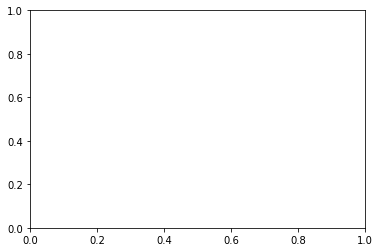

In [12]:
fig, ax = plt.subplots()
for color, region in [('C0', 'Inside10'), ('C1', '10to20'), ('C2', '20to30'),('C3','30to40'),('C4','40to50'),('C5','50to60'),('C6','60to70'),('C7','70to80'),('C8','80to90'),('C9','AndGoal')]:
    conv_pct3.loc[region].plot(
        ax=ax, y='rConvPct3', color=color, marker='.', ms=8, label='rConvPct3 ' + region)

ax.legend(loc=1)
ax.grid()


#### Final Values

Unlike for EPV which uses a simple line-fit regression model, we should run a more advanced regression model called LOWESS regression.  In simple terms, it is a curve fit instead of a straight line fit.  We clearly require this since we do not want straight lines for Expected Conversion Percentage.

Our final model for Expected Conversion Percentage will be in `exp_conv_pct_model`.

In [14]:
third_downs = extract_third_downs(pxp)
ignore_plays = ['Penalty', 'End Period', 'Timeout', 'End of Half', 'End of Game', 
        'No Play', 'Coin Toss', 'Extra Point Good','Blocked PAT','Extra Point Missed']
   
    
pxp['yrdregion'] = pd.cut(pxp['yrdline100'], [0., 9., 19., 29., 39., 49., 59., 69., 79., 89., 100.], labels=['Inside10', '10to20', '20to30', '30to40', '40to50', '50to60', '60to70', '70to80', '80to90', 'AndGoal'])
    
    #set display option
pd.set_option('display.max_rows', 1000)
    
conv_pct3 = third_downs.\
    groupby(['yrdregion', 'distance'])['1stdownconversion'].\
    mean().\
    to_frame()
conv_pct3.columns = ['rConvPct3']  # update column names


count3 = third_downs.\
    groupby(['yrdregion', 'distance'])['1stdownconversion'].\
    size().\
    to_frame()
count3.columns = ['count']  # update column names



result = pd.concat([conv_pct3, count3], axis=1)

In [18]:
fourth_downs = extract_fourth_downs(pxp)

    #set display option
pd.set_option('display.max_rows', 1000)
    
conv_pct4 = fourth_downs.\
    groupby(['yrdregion', 'distance'])['1stdownconversion4'].\
    mean().\
    to_frame()
conv_pct4.columns = ['rConvPct4']  # update column names


count4 = fourth_downs.\
    groupby(['yrdregion', 'distance'])['1stdownconversion4'].\
    size().\
    to_frame()
count4.columns = ['count']  # update column names

In [15]:
for region in ['Inside10', '10to20', '20to30', '30to40', '40to50', '50to60', '60to70', '70to80', '80to90', 'AndGoal']:
    conv_pct_region3 = conv_pct3.loc[region]
    conv_pct3.loc[region, 'ExpConvPct3'] = curve_fit(
        conv_pct_region3.index, conv_pct_region3['rConvPct3'])
    
exp_conv_pct_model3 = conv_pct3['ExpConvPct3']

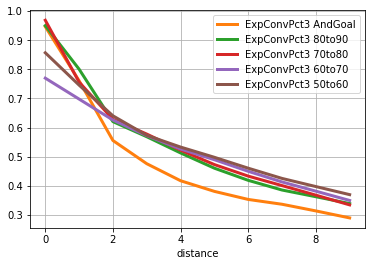

In [16]:
fig, ax = plt.subplots()
it = [(('C0', 'C1'), 'AndGoal'), (('C1', 'C2'), '80to90'),(('C2', 'C3'), '70to80'),(('C3', 'C4'), '60to70'),(('C4', 'C5'), '50to60')]
for (clr1, clr2), region in it:
    #conv_pct3.loc[region].plot(
        #ax=ax, y='rConvPct3', color=clr1, marker='.', ms=8, label='rConvPct3 ' + region)
    conv_pct3.loc[region].plot(
        ax=ax, y='ExpConvPct3', color=clr2, lw=3, label='ExpConvPct3 ' + region)

ax.legend(loc=1)
ax.grid()

In [ ]:
###

In [19]:
### 4th down conv
pd.set_option('display.max_rows', 1000)
conv_pct4 = fourth_downs.\
    groupby(['yrdregion', 'distance'])['1stdownconversion4'].\
    mean().\
    to_frame()
conv_pct4.columns = ['rConvPct4']  # update column names
conv_pct4

rConvPct4
yrdregion distance           
Inside10  0          0.563841
          1          0.616794
          2          0.512953
          3          0.460784
          4          0.338028
          5          0.305085
          6          0.420000
          7          0.387097
          8          0.382353
          9          0.250000
10to20    0          0.196970
          1          0.676737
          2          0.576577
          3          0.564103
          4          0.481818
          5          0.388889
          6          0.344828
          7          0.388889
          8          0.370968
          9          0.333333
20to30    0          0.250000
          1          0.695297
          2          0.564356
          3          0.494949
          4          0.475771
          5          0.450413
          6          0.435000
          7          0.402597
          8          0.394737
          9          0.357143
30to40    0          0.000000
          1          0.699015
          2          0.579909
          3          0.503717
          4          0.464066
          5          0.404092
          6          0.401216
          7          0.362319
          8          0.340336
          9          0.359116
40to50    0          0.600000
          1          0.723753
          2          0.604610
          3          0.484241
          4          0.474638
          5          0.439516
          6          0.433036
          7          0.352201
          8          0.335938
          9          0.352941
50to60    1          0.711405
          2          0.602128
          3          0.574405
          4          0.489627
          5          0.454545
          6          0.514451
          7          0.384615
          8          0.336283
          9          0.388889
60to70    0          0.166667
          1          0.727908
          2          0.604167
          3          0.568935
          4          0.506550
          5          0.452778
          6          0.433140
          7          0.405498
          8          0.363636
          9          0.439306
70to80    0          0.000000
          1          0.722078
          2          0.557203
          3          0.530973
          4          0.528090
          5          0.492308
          6          0.419214
          7          0.372093
          8          0.409396
          9          0.437500
80to90    0          0.244898
          1          0.708945
          2          0.579767
          3          0.503185
          4          0.506944
          5          0.439655
          6          0.463415
          7          0.329114
          8          0.360000
          9          0.303571
AndGoal   0          0.628743
          1          0.643289
          2          0.509579
          3          0.446809
          4          0.398148
          5          0.313953
          6          0.240000
          7          0.366667
          8          0.296296
          9          0.470588

In [20]:
pd.set_option('display.max_rows', 1000)
conv_pct4 = fourth_downs.\
    groupby(['yrdregion', 'distance'])['1stdownconversion4'].\
    size().\
    to_frame()
conv_pct4.columns = ['rConvPct4']  # update column names
conv_pct4

rConvPct4
yrdregion distance           
Inside10  0               979
          1               655
          2               193
          3               102
          4                71
          5                59
          6                50
          7                31
          8                34
          9                12
10to20    0                66
          1               662
          2               222
          3               156
          4               110
          5               108
          6                87
          7                72
          8                62
          9                60
20to30    0                 8
          1               978
          2               404
          3               297
          4               227
          5               242
          6               200
          7               154
          8               152
          9               112
30to40    0                 3
          1              1422
          2               657
          3               538
          4               487
          5               392
          6               329
          7               276
          8               238
          9               181
40to50    0                 5
          1              1524
          2               564
          3               349
          4               276
          5               248
          6               224
          7               159
          8               128
          9               102
50to60    1              1587
          2               470
          3               336
          4               241
          5               209
          6               173
          7               130
          8               113
          9                90
60to70    0                 6
          1              1573
          2               672
          3               573
          4               458
          5               360
          6               344
          7               291
          8               220
          9               173
70to80    0                13
          1              1155
          2               472
          3               339
          4               267
          5               260
          6               229
          7               172
          8               149
          9               128
80to90    0                49
          1               749
          2               257
          3               157
          4               144
          5               116
          6                82
          7                79
          8                75
          9                56
AndGoal   0              1002
          1               827
          2               261
          3               141
          4               108
          5                86
          6                50
          7                30
          8                27
          9                17

In [21]:
pd.set_option('display.max_rows', 1000)
conv_pct4 = fourth_downs.\
    groupby(['yrdregion', 'distance'])['1stdownconversion4'].\
    mean().\
    to_frame()
conv_pct4.columns = ['rConvPct4']  # update column names


count4 = fourth_downs.\
    groupby(['yrdregion', 'distance'])['1stdownconversion4'].\
    size().\
    to_frame()
count4.columns = ['count']  # update column names


count4
#result = pd.concat([conv_pct4, count4], axis=1)
#result.values.T.tolist()
#a =[result.columns.tolist()] + result.reset_index().values.tolist()
#type(a)

count
yrdregion distance       
Inside10  0           979
          1           655
          2           193
          3           102
          4            71
          5            59
          6            50
          7            31
          8            34
          9            12
10to20    0            66
          1           662
          2           222
          3           156
          4           110
          5           108
          6            87
          7            72
          8            62
          9            60
20to30    0             8
          1           978
          2           404
          3           297
          4           227
          5           242
          6           200
          7           154
          8           152
          9           112
30to40    0             3
          1          1422
          2           657
          3           538
          4           487
          5           392
          6           329
          7           276
          8           238
          9           181
40to50    0             5
          1          1524
          2           564
          3           349
          4           276
          5           248
          6           224
          7           159
          8           128
          9           102
50to60    1          1587
          2           470
          3           336
          4           241
          5           209
          6           173
          7           130
          8           113
          9            90
60to70    0             6
          1          1573
          2           672
          3           573
          4           458
          5           360
          6           344
          7           291
          8           220
          9           173
70to80    0            13
          1          1155
          2           472
          3           339
          4           267
          5           260
          6           229
          7           172
          8           149
          9           128
80to90    0            49
          1           749
          2           257
          3           157
          4           144
          5           116
          6            82
          7            79
          8            75
          9            56
AndGoal   0          1002
          1           827
          2           261
          3           141
          4           108
          5            86
          6            50
          7            30
          8            27
          9            17

In [22]:
result = pd.concat([conv_pct4, count4], axis=1)

result

rConvPct4  count
yrdregion distance                  
Inside10  0          0.563841    979
          1          0.616794    655
          2          0.512953    193
          3          0.460784    102
          4          0.338028     71
          5          0.305085     59
          6          0.420000     50
          7          0.387097     31
          8          0.382353     34
          9          0.250000     12
10to20    0          0.196970     66
          1          0.676737    662
          2          0.576577    222
          3          0.564103    156
          4          0.481818    110
          5          0.388889    108
          6          0.344828     87
          7          0.388889     72
          8          0.370968     62
          9          0.333333     60
20to30    0          0.250000      8
          1          0.695297    978
          2          0.564356    404
          3          0.494949    297
          4          0.475771    227
          5          0.450413    242
          6          0.435000    200
          7          0.402597    154
          8          0.394737    152
          9          0.357143    112
30to40    0          0.000000      3
          1          0.699015   1422
          2          0.579909    657
          3          0.503717    538
          4          0.464066    487
          5          0.404092    392
          6          0.401216    329
          7          0.362319    276
          8          0.340336    238
          9          0.359116    181
40to50    0          0.600000      5
          1          0.723753   1524
          2          0.604610    564
          3          0.484241    349
          4          0.474638    276
          5          0.439516    248
          6          0.433036    224
          7          0.352201    159
          8          0.335938    128
          9          0.352941    102
50to60    1          0.711405   1587
          2          0.602128    470
          3          0.574405    336
          4          0.489627    241
          5          0.454545    209
          6          0.514451    173
          7          0.384615    130
          8          0.336283    113
          9          0.388889     90
60to70    0          0.166667      6
          1          0.727908   1573
          2          0.604167    672
          3          0.568935    573
          4          0.506550    458
          5          0.452778    360
          6          0.433140    344
          7          0.405498    291
          8          0.363636    220
          9          0.439306    173
70to80    0          0.000000     13
          1          0.722078   1155
          2          0.557203    472
          3          0.530973    339
          4          0.528090    267
          5          0.492308    260
          6          0.419214    229
          7          0.372093    172
          8          0.409396    149
          9          0.437500    128
80to90    0          0.244898     49
          1          0.708945    749
          2          0.579767    257
          3          0.503185    157
          4          0.506944    144
          5          0.439655    116
          6          0.463415     82
          7          0.329114     79
          8          0.360000     75
          9          0.303571     56
AndGoal   0          0.628743   1002
          1          0.643289    827
          2          0.509579    261
          3          0.446809    141
          4          0.398148    108
          5          0.313953     86
          6          0.240000     50
          7          0.366667     30
          8          0.296296     27
          9          0.470588     17

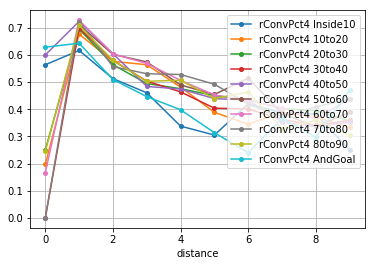

In [23]:
fig, ax = plt.subplots()
for color, region in [('C0', 'Inside10'), ('C1', '10to20'), ('C2', '20to30'),('C3','30to40'),('C4','40to50'),('C5','50to60'),('C6','60to70'),('C7','70to80'),('C8','80to90'),('C9','AndGoal')]:
    conv_pct4.loc[region].plot(
        ax=ax, y='rConvPct4', color=color, marker='.', ms=8, label='rConvPct4 ' + region)

ax.legend(loc=1)
ax.grid()

In [24]:
for region in ['Inside10', '10to20', '20to30', '30to40', '40to50', '50to60', '60to70', '70to80', '80to90', 'AndGoal']:
    conv_pct_region4 = conv_pct4.loc[region]
    conv_pct4.loc[region, 'ExpConvPct4'] = curve_fit(
        conv_pct_region4.index, conv_pct_region4['rConvPct4'])
    
exp_conv_pct_model4 = conv_pct4['ExpConvPct4']

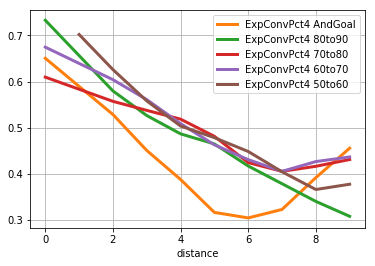

In [25]:
fig, ax = plt.subplots()
it = [(('C0', 'C1'), 'AndGoal'), (('C1', 'C2'), '80to90'),(('C2', 'C3'), '70to80'),(('C3', 'C4'), '60to70'),(('C4', 'C5'), '50to60')]
for (clr1, clr2), region in it:
    #conv_pct4.loc[region].plot(
        #ax=ax, y='rConvPct4', color=clr1, marker='.', ms=8, label='rConvPct4 ' + region)
    conv_pct4.loc[region].plot(
        ax=ax, y='ExpConvPct4', color=clr2, lw=3, label='ExpConvPct4 ' + region)

ax.legend(loc=1)
ax.grid()